In [3]:
import json
import os
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

results_dir = '.'
def flatten_dict(d, target_key = 'per_dataset_modality_task_dice'):
    """Flattens the nested dictionary d to tuple keys."""
    save = {}
    for key in d[target_key]:
        dictt = {    }
        for k in d[target_key][key]:
            for task in d[target_key][key][k]:
                dictt[(k, task)] = d[target_key][key][k][task]
        
        save[key] = dictt
    return save


,,,0
Baseline,MRI,prostate,0.324510
SegVol-Prior,MRI,prostate,0.845833


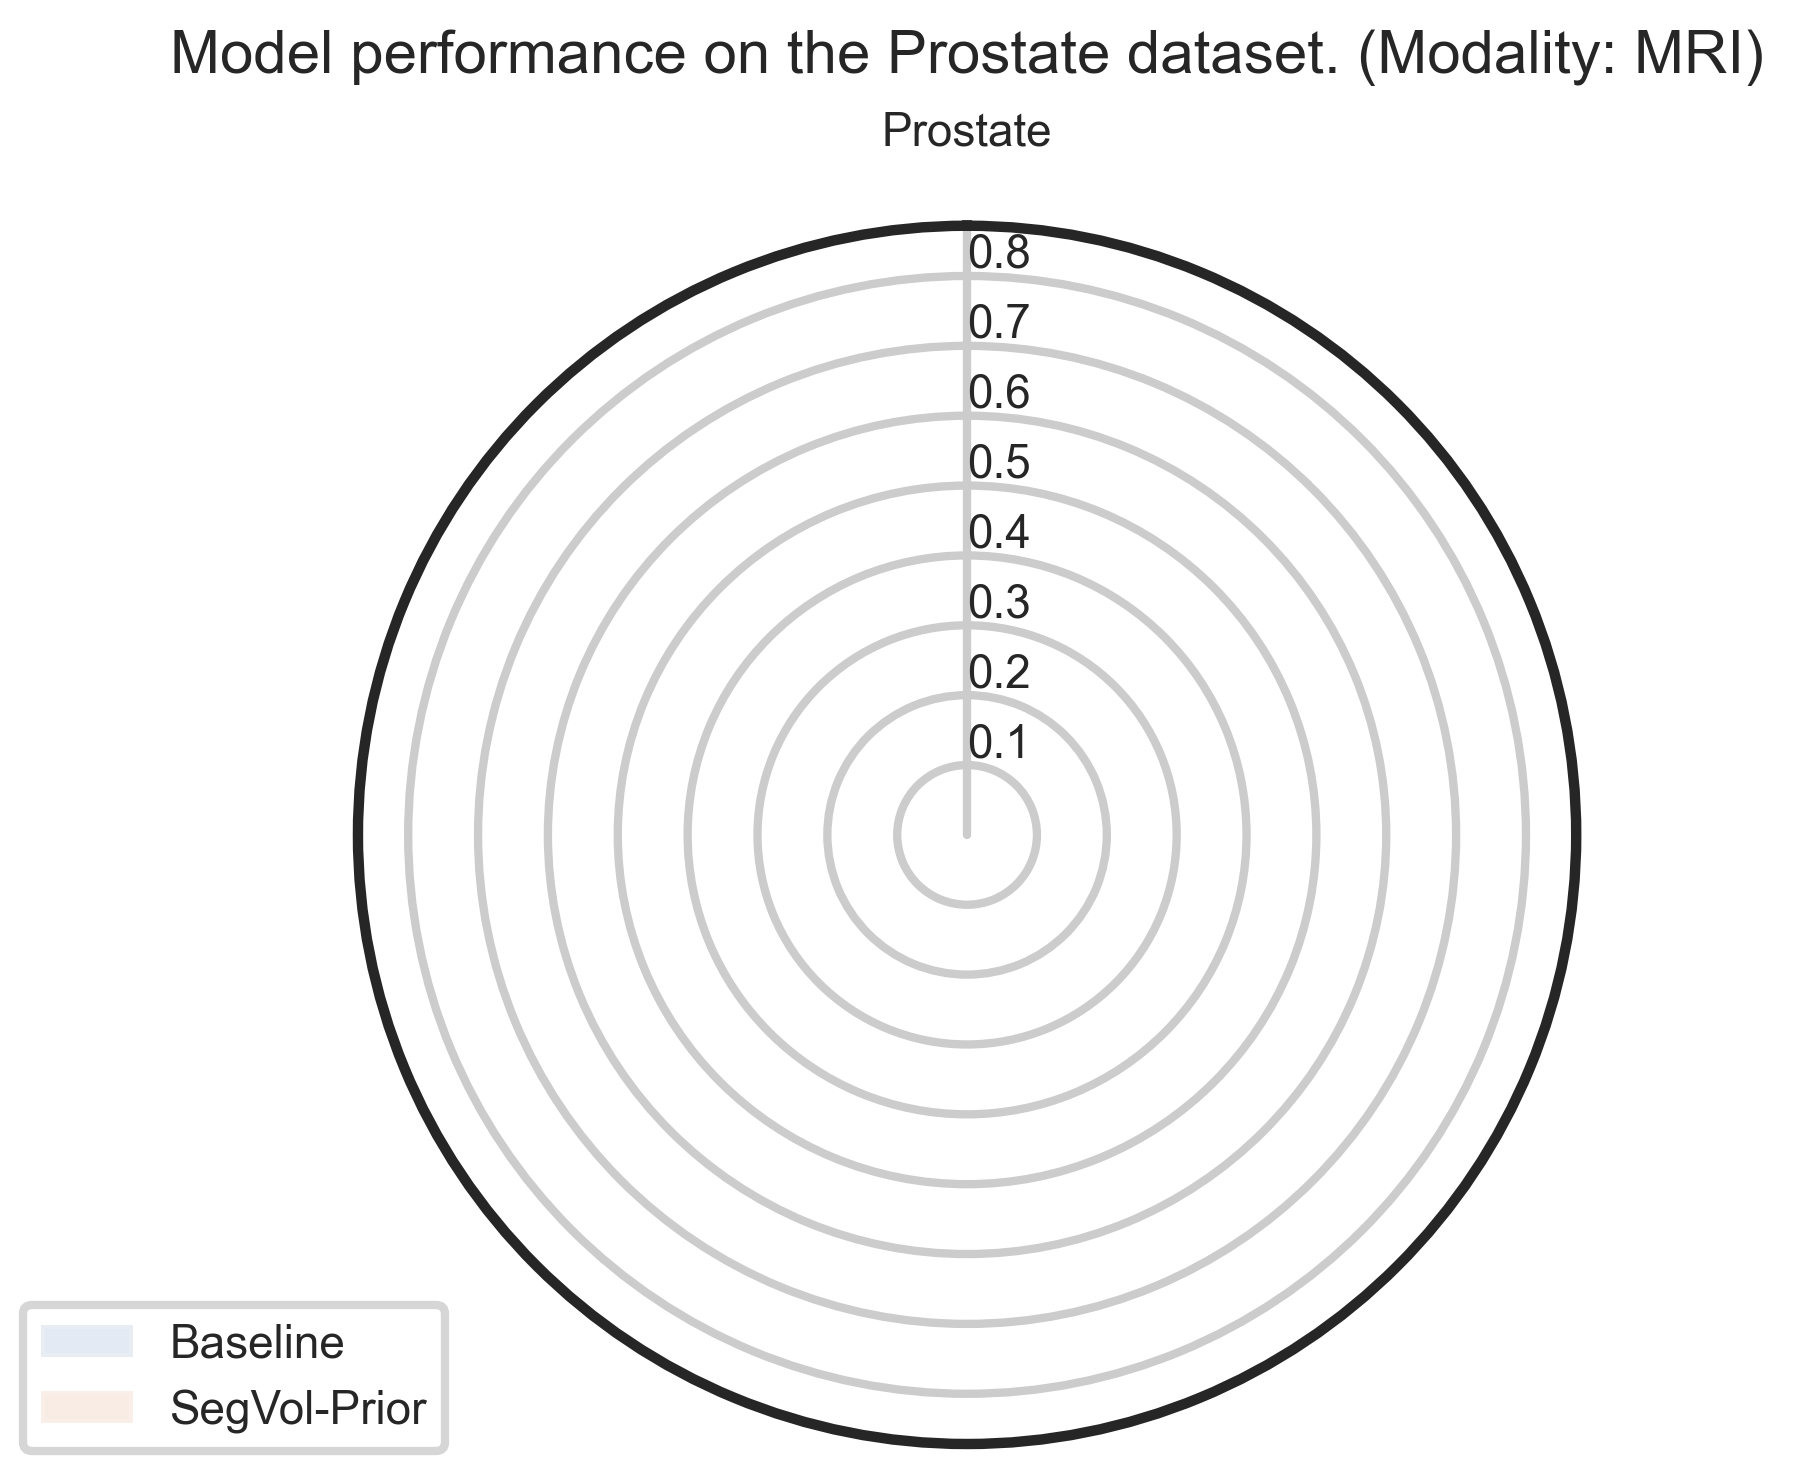

0
Baseline     MRI prostate         0.382315
                 Enhancing Tumor  0.236381
                 Edema            0.405408
                 right kidney     0.904191
                 liver            0.725064
...                                    ...
SegVol-Prior CT  colon cancer     0.678117
                 liver            0.958149
                 tumour           0.575005
                 pancreas         0.765545
                 spleen           0.962918

[62 rows x 1 columns]

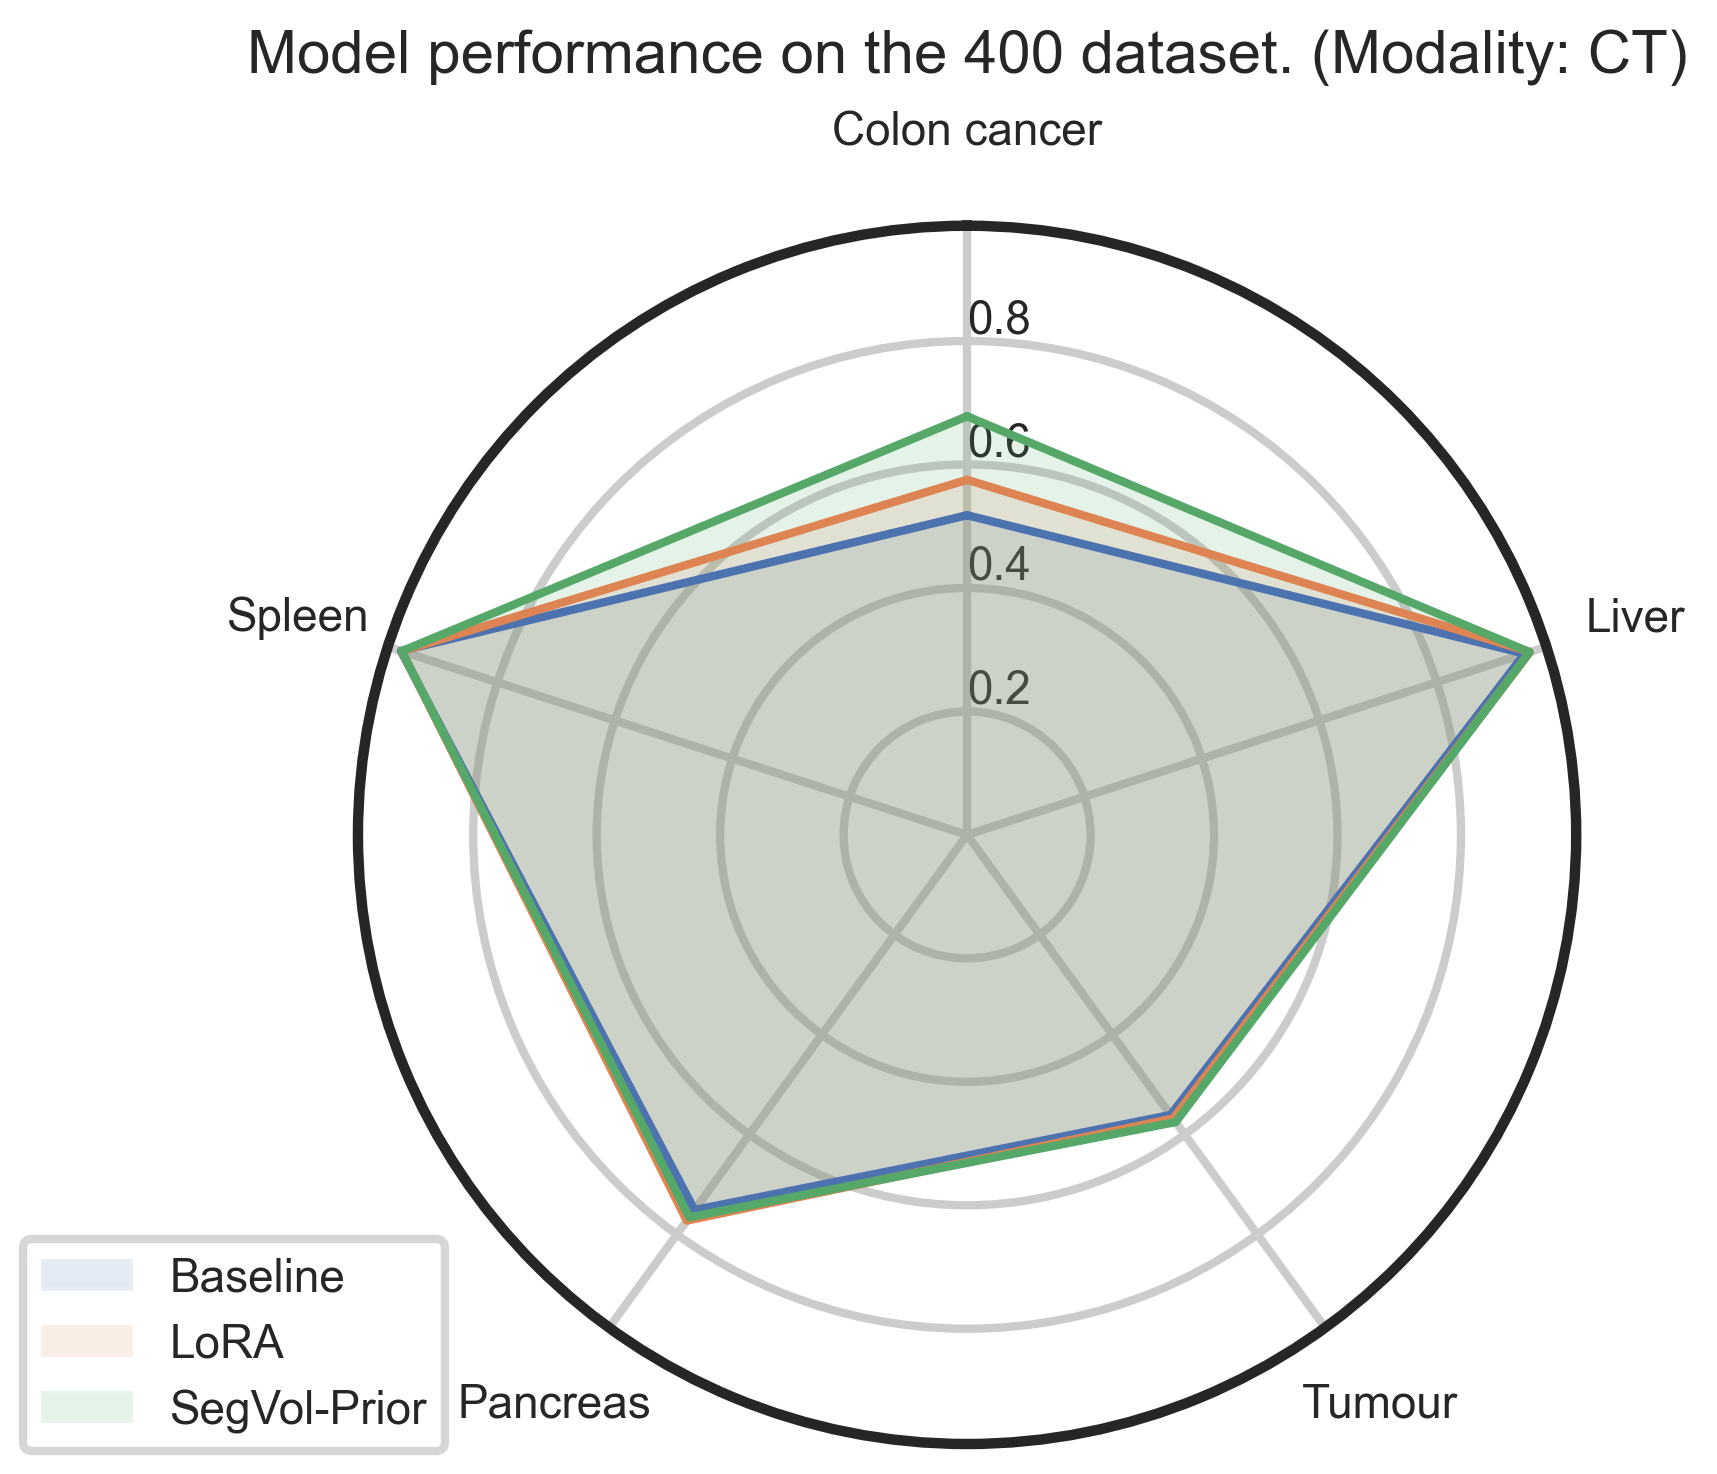

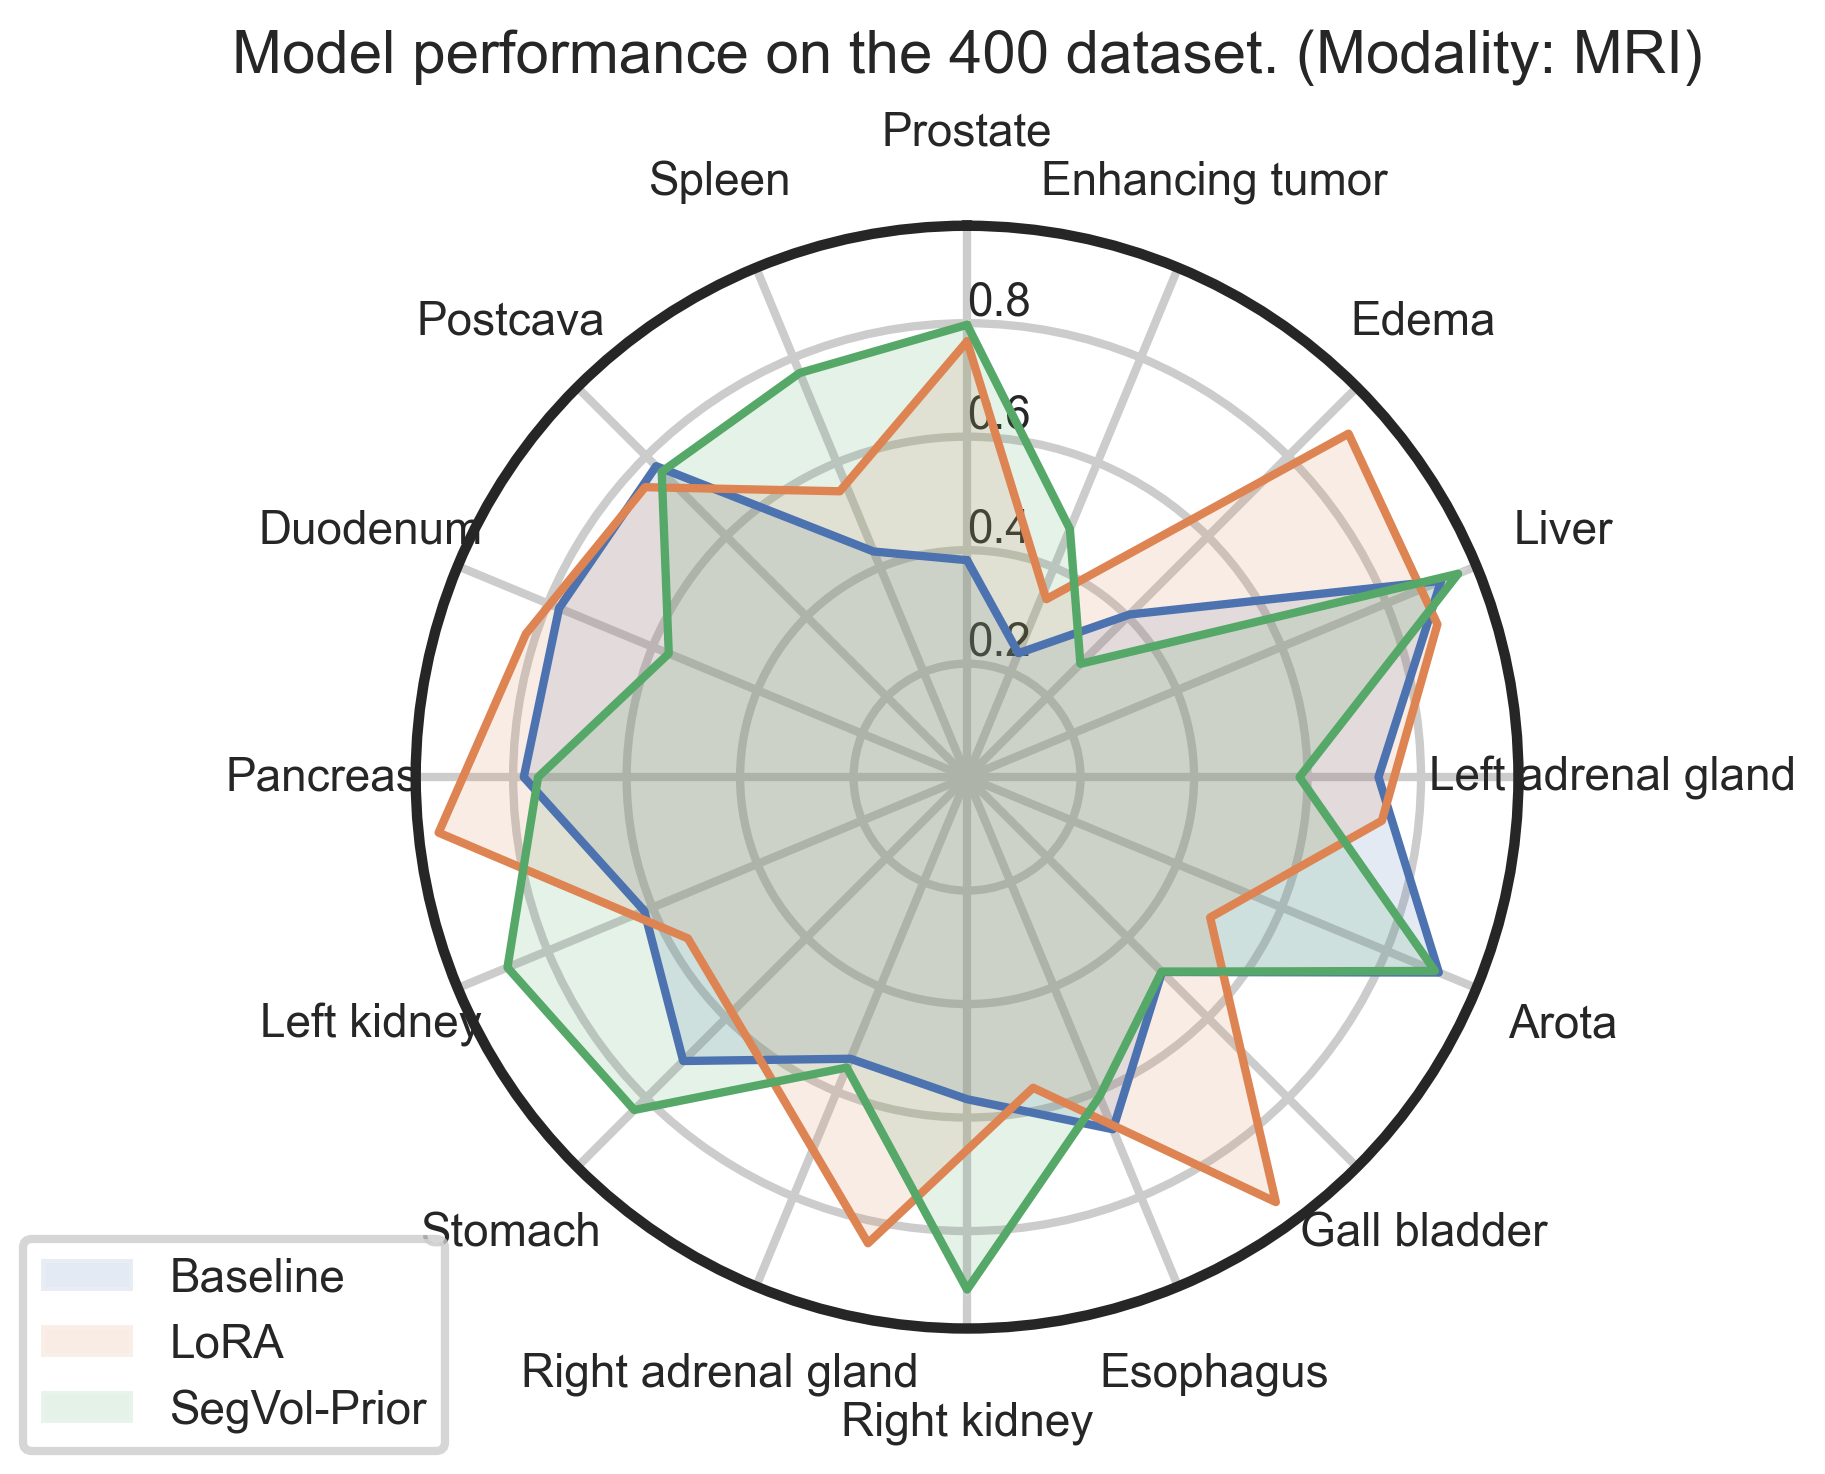

In [5]:
def draw_spider_chart(series: pd.Series, ax, label):

    # Prepare data
    labels = series.index
    labels = list(map(str.capitalize, labels))
    values = series.values

    # Number of variables
    num_vars = len(labels)

    # Compute angle for each axis
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    # The plot is a circle, so we need to "complete the loop"
    values = np.concatenate((values, [values[0]]))
    angles += angles[:1]

    # Draw one axe per variable and add labels
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    # Draw the axes with labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)

    # Draw y-labels
    ax.set_rscale('linear')
    ax.set_rlabel_position(0)
    ax.plot(angles, values, linewidth=2, linestyle='solid')
    ax.fill(angles, values, alpha=0.15, label=label)

    return fig, ax

files = os.listdir(results_dir)
groups = defaultdict(list)
# Group files by dataset
for file in files:
    if not file.endswith('.json'):
        continue
    dataset = file.rsplit('_')[-1]
    groups[dataset] += [file]


import seaborn as sns
sns.set_theme(
    context="poster",
    style="ticks",
    font_scale=0.5,
    rc={"figure.dpi": 300, "figure.constrained_layout.use": True, "lines.linewidth": 3},
)

for dataset, files in groups.items():
    dfs = []
    names = []
    for file in sorted(files):
        with open(os.path.join(results_dir, file), 'r') as f:
            data = json.load(f)
            data = flatten_dict(data)
            df = pd.DataFrame.from_dict(data, orient='index')
            
            df = df.dropna(axis=1, how='all')
            df = df.agg('mean')
            dfs.append(df)
            names.append(file.split('_')[0])
        
    df = pd.concat(dfs, sort=True,keys=names)
    df = pd.DataFrame(df) # don't think about it
    df = df[df > 0.2]
    df = df.dropna(how='all')
    display(df)
    for mod in df.index.levels[1]:
        fig, axs = plt.subplots(subplot_kw=dict(polar=True))
        for i, name in enumerate(names):
            _, ax = draw_spider_chart(df.loc[name].loc[mod], axs, name)
            # axs[i].set_label(mod)
        # axs.legend(names)
        fig.legend(loc='lower left')
        # axs.set_title(f'Model performance on the {dataset[:-5].capitalize()} dataset. (Modality: {mod})')
        fig.suptitle(f'Model performance on the {dataset[:-5].capitalize()} dataset. (Modality: {mod})')
        plt.show()

# pd.DataFrame(df).index.levels[1]
# Show the plot
# plt.show()


In [57]:
df

CT                                          \
                      colon cancer     liver  pancreas    spleen    tumour   
MSD_mr_42                      NaN       NaN       NaN       NaN       NaN   
T2-weighted-MRI_mr_42          NaN       NaN       NaN       NaN       NaN   
promise12_mr_42                NaN       NaN       NaN       NaN       NaN   
SAML_mr_42                     NaN       NaN       NaN       NaN       NaN   
brats_mr_42                    NaN       NaN       NaN       NaN       NaN   
amos_mrct_42                   NaN       NaN       NaN       NaN       NaN   
chaos_mrct_42                  NaN       NaN       NaN       NaN       NaN   
0018 Dataset              0.575204       NaN       NaN       NaN       NaN   
0020 Dataset                   NaN  0.958793       NaN       NaN  0.482366   
0022 Dataset                   NaN       NaN  0.772360       NaN  0.653404   
0023 Dataset                   NaN       NaN       NaN  0.962802       NaN   
MSD_mr_42                      NaN       NaN       NaN       NaN       NaN   
T2-weighted-MRI_mr_42          NaN       NaN       NaN       NaN       NaN   
promise12_mr_42                NaN       NaN       NaN       NaN       NaN   
SAML_mr_42                     NaN       NaN       NaN       NaN       NaN   
brats_mr_42                    NaN       NaN       NaN       NaN       NaN   
amos_mrct_42                   NaN       NaN       NaN       NaN       NaN   
chaos_mrct_42                  NaN       NaN       NaN       NaN       NaN   
0018 Dataset              0.678117       NaN       NaN       NaN       NaN   
0020 Dataset                   NaN  0.958149       NaN       NaN  0.490639   
0022 Dataset                   NaN       NaN  0.765545       NaN  0.659370   
0023 Dataset                   NaN       NaN       NaN  0.962918       NaN   

                            MRI                  \
                          Edema Enhancing Tumor   
MSD_mr_42                   NaN             NaN   
T2-weighted-MRI_mr_42       NaN             NaN   
promise12_mr_42             NaN             NaN   
SAML_mr_42                  NaN             NaN   
brats_mr_42            0.002305        0.343241   
amos_mrct_42                NaN             NaN   
chaos_mrct_42               NaN             NaN   
0018 Dataset                NaN             NaN   
0020 Dataset                NaN             NaN   
0022 Dataset                NaN             NaN   
0023 Dataset                NaN             NaN   
MSD_mr_42                   NaN             NaN   
T2-weighted-MRI_mr_42       NaN             NaN   
promise12_mr_42             NaN             NaN   
SAML_mr_42                  NaN             NaN   
brats_mr_42            0.282421        0.473366   
amos_mrct_42                NaN             NaN   
chaos_mrct_42               NaN             NaN   
0018 Dataset                NaN             NaN   
0020 Dataset                NaN             NaN   
0022 Dataset                NaN             NaN   
0023 Dataset                NaN             NaN   

                                                                           \
                      Non-Contrast-Enhancing Tumor Core     arota bladder   
MSD_mr_42                                           NaN       NaN     NaN   
T2-weighted-MRI_mr_42                               NaN       NaN     NaN   
promise12_mr_42                                     NaN       NaN     NaN   
SAML_mr_42                                          NaN       NaN     NaN   
brats_mr_42                                    0.024867       NaN     NaN   
amos_mrct_42                                        NaN  0.839851     0.0   
chaos_mrct_42                                       NaN       NaN     NaN   
0018 Dataset                                        NaN       NaN     NaN   
0020 Dataset                                        NaN       NaN     NaN   
0022 Dataset                                        NaN       NaN     NaN   
0023 Datas